In [1]:
from ROOT import TFile, TTree, TMVA, TCut, TH1F, TH2F, TCanvas, TPad

import numpy as np
from array import array

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.utils.data as Data

Welcome to JupyROOT 6.28/02


In [2]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

In [3]:
class NetworkModel(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(NetworkModel, self).__init__()
        self.hid1 = nn.Linear(n_features, n_hidden)
        self.hid2 = nn.Linear(n_hidden, n_hidden)
        self.hid3 = nn.Linear(n_hidden, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.sigmoid(self.hid1(x))
        x = torch.sigmoid(self.hid2(x))
        x = torch.sigmoid(self.hid3(x))
        x = self.output(x)
        return x

modelx = NetworkModel(4, 256, 1)

In [4]:
def train(model, trainloader, valloader, num_epochs,
          batch_size, optimizer, criterion, save_best, scheduler):
    trainer = optimizer(model.parameters(), lr=0.01)
    schedule, scheduleSteps = scheduler
    best_val = None
    
    for epoch in range(num_epochs):
        running_loss_train = 0.0
        running_loss_val = 0.0
        
        model.train()
        for i, (X, y) in enumerate(trainloader):
            X = Variable(X)
            y = Variable(y)
            
            trainer.zero_grad()
            output = model(X)
            train_loss = criterion(output, y)
            train_loss.backward()
            trainer.step()
            
            running_loss_train += train_loss.item()
            if i % 32 == 31:
                print('[Epoch {}, Item {}] Training Loss: {:.3f}'
                      .format(epoch+1, i+1, running_loss_train / 32))
                running_loss_train = 0.0
            
        if schedule:
            schedule(optimizer, epoch, schedulerSteps)
            
        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(valloader):
                X = Variable(X)
                y = Variable(y)
                
                output = model(X)
                val_loss = criterion(output, y)
                running_loss_val += val_loss.item()
            
            curr_val = running_loss_val / len(valloader)
            if save_best:
                if best_val == None:
                    best_val = curr_val
                best_val = save_best(model, curr_val, best_val)
            
            print('[Epoch {}] Validation Loss: {:.3f}'
                      .format(epoch+1, curr_val))
            running_loss_val = 0.0
    
    print('Finished training!')
    return model

In [5]:
def predict(model, test_X, batch_size=32):
    model.eval()
    
    test_dataset = Data.TensorDataset(torch.Tensor(test_X))
    testloader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for i, data in enumerate(testloader):
            X = Variable(data[0])
            
            output = model(X)
            predictions.append(output)
        preds = torch.cat(predictions)
    
    return preds.numpy()

In [6]:
output_file = TFile.Open('dis_regression_results_x.root', 'RECREATE')

factory = TMVA.Factory('DIS_Regression', output_file,
                      '!V:!Silent:Color:DrawProgressBar:AnalysisType=Regression')
dataloader = TMVA.DataLoader('dataset_x')

dataloader.AddVariable('electron_final_state.eta')
dataloader.AddVariable('electron_final_state.final_energy')
dataloader.AddVariable('hadron_final_state.Epz')
dataloader.AddVariable('hadron_final_state.squared_pt')

dataloader.AddTarget('electron_method_outputs.x')

In [7]:
dis_file = TFile.Open('dis_values.root', 'READ')
dis_tree = dis_file.Get('dis_tree')

dataloader.AddRegressionTree(dis_tree, 1.0)

dataloader.PrepareTrainingAndTestTree(TCut(''),
    'nTrain_Regression=2000:SplitMode=Random:NormMode=NumEvents:!V')

DataSetInfo              : [dataset_x] : Added class "Regression"
                         : Add Tree dis_tree of type Regression with 8000 events
                         : Dataset[dataset_x] : Class index : 0  name : Regression


In [8]:
optimizer = optim.SGD
criterion = nn.MSELoss()

load_model_custom_objects = {
    'optimizer': optimizer,
    'criterion': criterion,
    'train_func': train,
    'predict_func': predict
}

mx = torch.jit.script(modelx)
torch.jit.save(mx, 'modelRegressionx.pt')

print(mx)

RecursiveScriptModule(
  original_name=NetworkModel
  (hid1): RecursiveScriptModule(original_name=Linear)
  (hid2): RecursiveScriptModule(original_name=Linear)
  (hid3): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)


In [9]:
factory.BookMethod(dataloader, TMVA.Types.kPyTorch, 'PyTorch',
                  '!H:!V:VarTransform=D,G:'+
                   'FilenameModel=modelRegressionx.pt:'+
                   'FilenameTrainedModel=trainedModelRegressionx.pt:'+
                   'NumEpochs=200:BatchSize=32')

factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

custom objects for loading model :  {'optimizer': <class 'torch.optim.sgd.SGD'>, 'criterion': MSELoss(), 'train_func': <function train at 0x7fdd5691e5f0>, 'predict_func': <function predict at 0x7fdd5691e950>}
RecursiveScriptModule(
  original_name=NetworkModel
  (hid1): RecursiveScriptModule(original_name=Linear)
  (hid2): RecursiveScriptModule(original_name=Linear)
  (hid3): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)
[Epoch 1, Item 32] Training Loss: 0.023
[Epoch 1] Validation Loss: 0.019
[Epoch 2, Item 32] Training Loss: 0.023
[Epoch 2] Validation Loss: 0.019
[Epoch 3, Item 32] Training Loss: 0.023
[Epoch 3] Validation Loss: 0.019
[Epoch 4, Item 32] Training Loss: 0.023
[Epoch 4] Validation Loss: 0.019
[Epoch 5, Item 32] Training Loss: 0.023
[Epoch 5] Validation Loss: 0.019
[Epoch 6, Item 32] Training Loss: 0.023
[Epoch 6] Validation Loss: 0.019
[Epoch 7, Item 32] Training Loss: 0.023
[Epoch 7] Validation Loss: 0.019
[Epoch 8

[Epoch 105] Validation Loss: 0.013
[Epoch 106, Item 32] Training Loss: 0.017
[Epoch 106] Validation Loss: 0.013
[Epoch 107, Item 32] Training Loss: 0.017
[Epoch 107] Validation Loss: 0.013
[Epoch 108, Item 32] Training Loss: 0.016
[Epoch 108] Validation Loss: 0.013
[Epoch 109, Item 32] Training Loss: 0.016
[Epoch 109] Validation Loss: 0.013
[Epoch 110, Item 32] Training Loss: 0.016
[Epoch 110] Validation Loss: 0.013
[Epoch 111, Item 32] Training Loss: 0.016
[Epoch 111] Validation Loss: 0.013
[Epoch 112, Item 32] Training Loss: 0.016
[Epoch 112] Validation Loss: 0.013
[Epoch 113, Item 32] Training Loss: 0.016
[Epoch 113] Validation Loss: 0.013
[Epoch 114, Item 32] Training Loss: 0.016
[Epoch 114] Validation Loss: 0.012
[Epoch 115, Item 32] Training Loss: 0.016
[Epoch 115] Validation Loss: 0.012
[Epoch 116, Item 32] Training Loss: 0.016
[Epoch 116] Validation Loss: 0.012
[Epoch 117, Item 32] Training Loss: 0.016
[Epoch 117] Validation Loss: 0.012
[Epoch 118, Item 32] Training Loss: 0.016

0%, time left: unknown
7%, time left: 1 sec
13%, time left: 0 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 2 sec
13%, time left: 2 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 1 sec
44%, time left: 1 sec
50%, time left: 0 sec
57%, time left: 1 sec
63%, time left: 1 sec
69%, time left: 1 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 1 sec
13%, time left: 1 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 1 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

In [10]:
def get_log_bins(nbins, xmin, xmax):
    xbins = []
    base = np.exp((np.log(xmax) - np.log(xmin)) / nbins)
    
    for i in range(nbins):
        xbins.append(xmin * np.power(base, i))
    xbins.append(xmax)
    
    return array('d', xbins)

In [11]:
tree = output_file.Get('dataset_x/TestTree')
ml_res = tree.GetLeaf('PyTorch.electron_method_outputs.x')
em_x = tree.GetLeaf('electron_method_outputs.x')

ml_x_hist = TH1F('ml_x', 'x (Machine Learning Reconstruction)', 20, get_log_bins(20, 1e-3, 1))
e_ml_x = TH2F('e_ml_x', 'Electron method vs. Machine Learning for reconstruction of x', 20, get_log_bins(20, 1e-3, 1), 20, get_log_bins(20, 1e-3, 1))

for ev in tree:
    for i in range(ml_res.GetLen()):
        ml_x_hist.Fill(ml_res.GetValue(i))
        e_ml_x.Fill(em_x.GetValue(i), ml_res.GetValue(i))

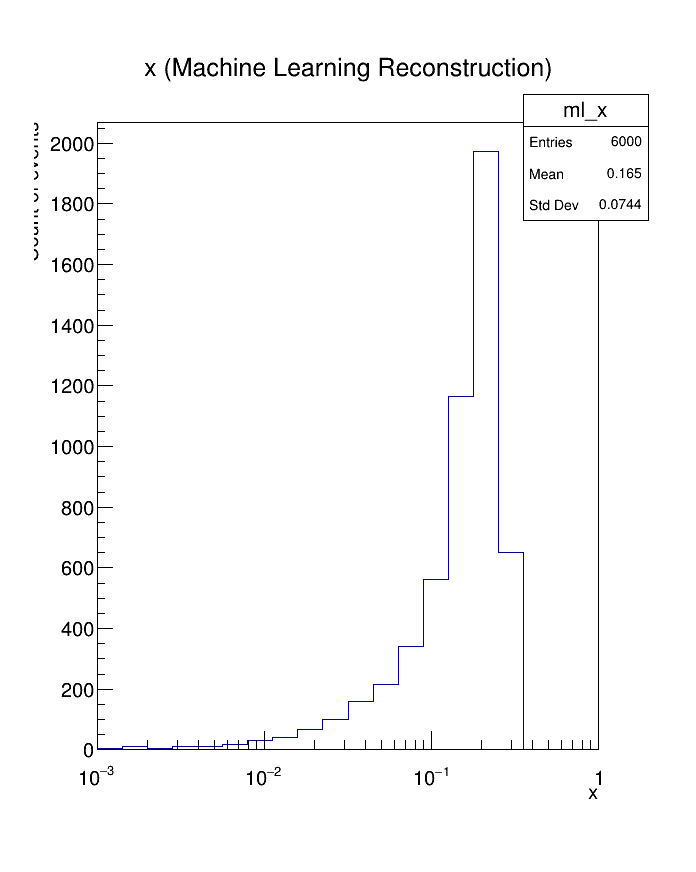

In [12]:
c_ml_x = TCanvas('c_ml_x', 'The canvas with x histogram', 200, 10, 700, 900)
pad_ml_x = TPad('pad_ml_x', 'The pad with x histogram', 0.05, 0.05, 0.95, 0.95)

pad_ml_x.Draw()
pad_ml_x.cd()
pad_ml_x.SetLogx()

ml_x_hist.GetXaxis().SetTitle('x')
ml_x_hist.GetYaxis().SetTitle('Count of events')
ml_x_hist.Draw()

c_ml_x.Update()
c_ml_x.Draw()

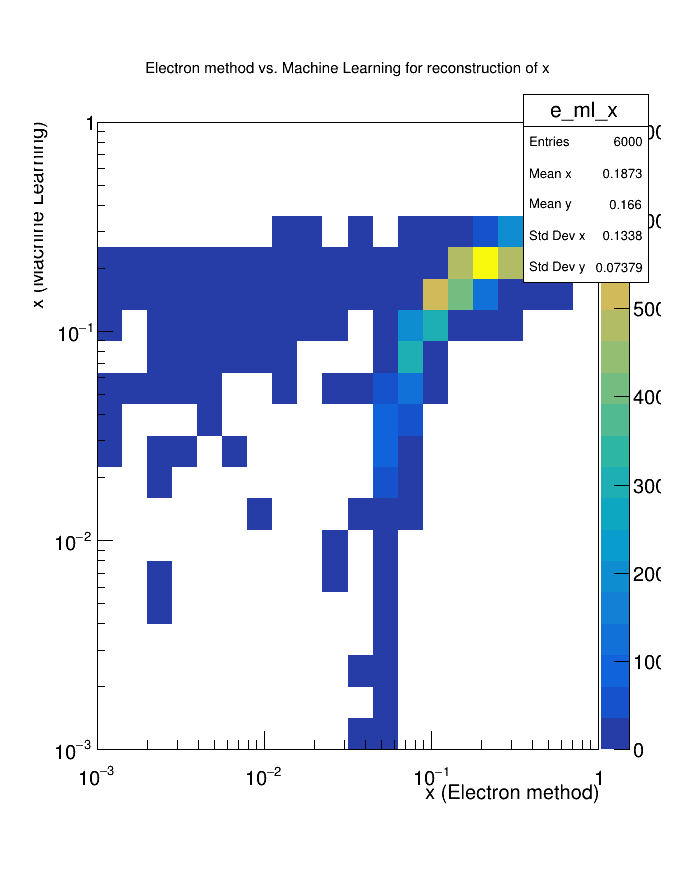

In [13]:
c_e_ml_x = TCanvas('c_e_ml_x', 'The canvas with e vs. JB x', 200, 10, 700, 900)
pad_e_ml_x = TPad('pad_e_ml_x', 'The pad with e vs. JB x', 0.05, 0.05, 0.95, 0.95)

pad_e_ml_x.Draw()
pad_e_ml_x.cd()
pad_e_ml_x.SetLogx()
pad_e_ml_x.SetLogy()

e_ml_x.GetXaxis().SetTitle('x (Electron method)')
e_ml_x.GetYaxis().SetTitle('x (Machine Learning)')
e_ml_x.Draw('colz')

c_e_ml_x.Update()
c_e_ml_x.Draw()

In [14]:
output_file.Close()